In [149]:
%matplotlib inline
from multiprocessing import Pool

import numpy as np
import matplotlib.pyplot as plt

import astropy.units as u
from astropy.time import Time

from emcee import EnsembleSampler
from fleck import Star
from lightkurve import search_lightcurvefile
from corner import corner

lcf = search_lightcurvefile('AU Mic', mission='TESS').download()
lc = lcf.get_lightcurve('PDCSAP_FLUX')

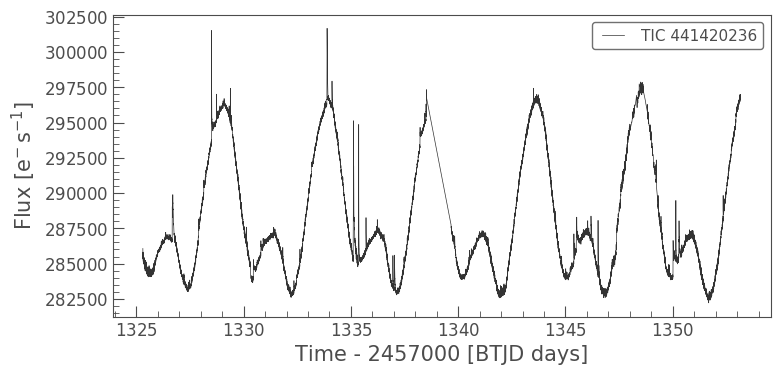

In [150]:
astropy_time = Time(lc.time + 2457000, format='jd')
flux_observed = lc.flux / np.nanmin(lc.flux)

lc.plot()

In [202]:
prot = 4.865
star = Star(spot_contrast=10, u_ld=[0.4, 0.2], rotation_period=prot, 
            phases=(astropy_time.jd % prot) / prot)

init_lons = np.array([60, 220, 0])
init_lats = np.array([20, 0, 0])
init_rads = np.array([0.065, 0.04, 0.03])

lons = init_lons[:, None] * u.deg
lats = init_lats[:, None] * u.deg
rads = init_rads[:, None]

flux_model = star.light_curve(lons, lats, rads, inc_stellar=90*u.deg, times=astropy_time.jd)

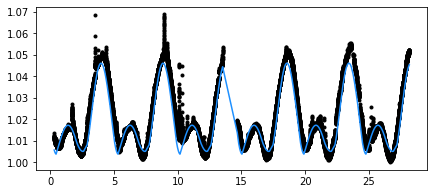

In [203]:
fig, ax = plt.subplots(figsize=(7, 3), sharex=True)
btjd_mid = int(astropy_time.jd.min())

ax.plot(astropy_time.jd - btjd_mid, 
           flux_observed, 'k.')

ax.plot(astropy_time.jd - btjd_mid, 
           flux_model, color='DodgerBlue')
plt.show()

In [204]:
yerr = 0.0001

def log_likelihood(p):
    lons = p[0:3]
    lats = p[3:6]
    rads = p[6:9]
    
    lc = star.light_curve(lons[:, None] * u.deg, lats[:, None] * u.deg, rads[:, None], 
                          inc_stellar=90*u.deg, times=astropy_time.jd, time_ref=0)[:, 0]
    
#     plt.plot(flux_observed)
#     plt.plot(lc)
#     plt.show()
    
    return - 0.5 * np.nansum((lc - flux_observed)**2 / yerr**2)
    
def log_prior(p): 
    lons = p[0:3]
    lats = p[3:6]
    rads = p[6:9]
    
    if (np.all(rads < 0.1) and np.all(rads > 0) and np.all(lats > -85) and 
        np.all(lats < 85) and np.all(lons > 0) and np.all(lons < 360)): 
        return 0
    return -np.inf

def log_probability(p):
    lp = log_prior(p)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(p)

init_p = np.concatenate([init_lons, init_lats, init_rads])

ndim = len(init_p)
nwalkers = 2 * ndim
nsteps = 1000

pos = []

while len(pos) < nwalkers: 
    trial = init_p + 0.01 * np.random.randn(ndim)
    lp = log_prior(trial)
    if np.isfinite(lp):
        pos.append(trial)

In [205]:
# sampler = EnsembleSampler(nwalkers, ndim, log_probability)
# sampler.run_mcmc(pos, nsteps, progress=True);

with Pool() as pool:
    sampler = EnsembleSampler(nwalkers, ndim, log_probability, pool=pool)
    sampler.run_mcmc(pos, nsteps, progress=True);

 78%|███████▊  | 777/1000 [01:30<00:28,  7.96it/s]/Users/bmmorris/miniconda3/lib/python3.7/site-packages/fleck-0.0.dev67-py3.7.egg/fleck/core.py:34: RuntimeWarning: invalid value encountered in sqrt
  mu = np.sqrt(1 - r**2)
/Users/bmmorris/miniconda3/lib/python3.7/site-packages/fleck-0.0.dev67-py3.7.egg/fleck/core.py:250: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(1 - r**2))
100%|██████████| 1000/1000 [01:59<00:00,  8.18it/s]


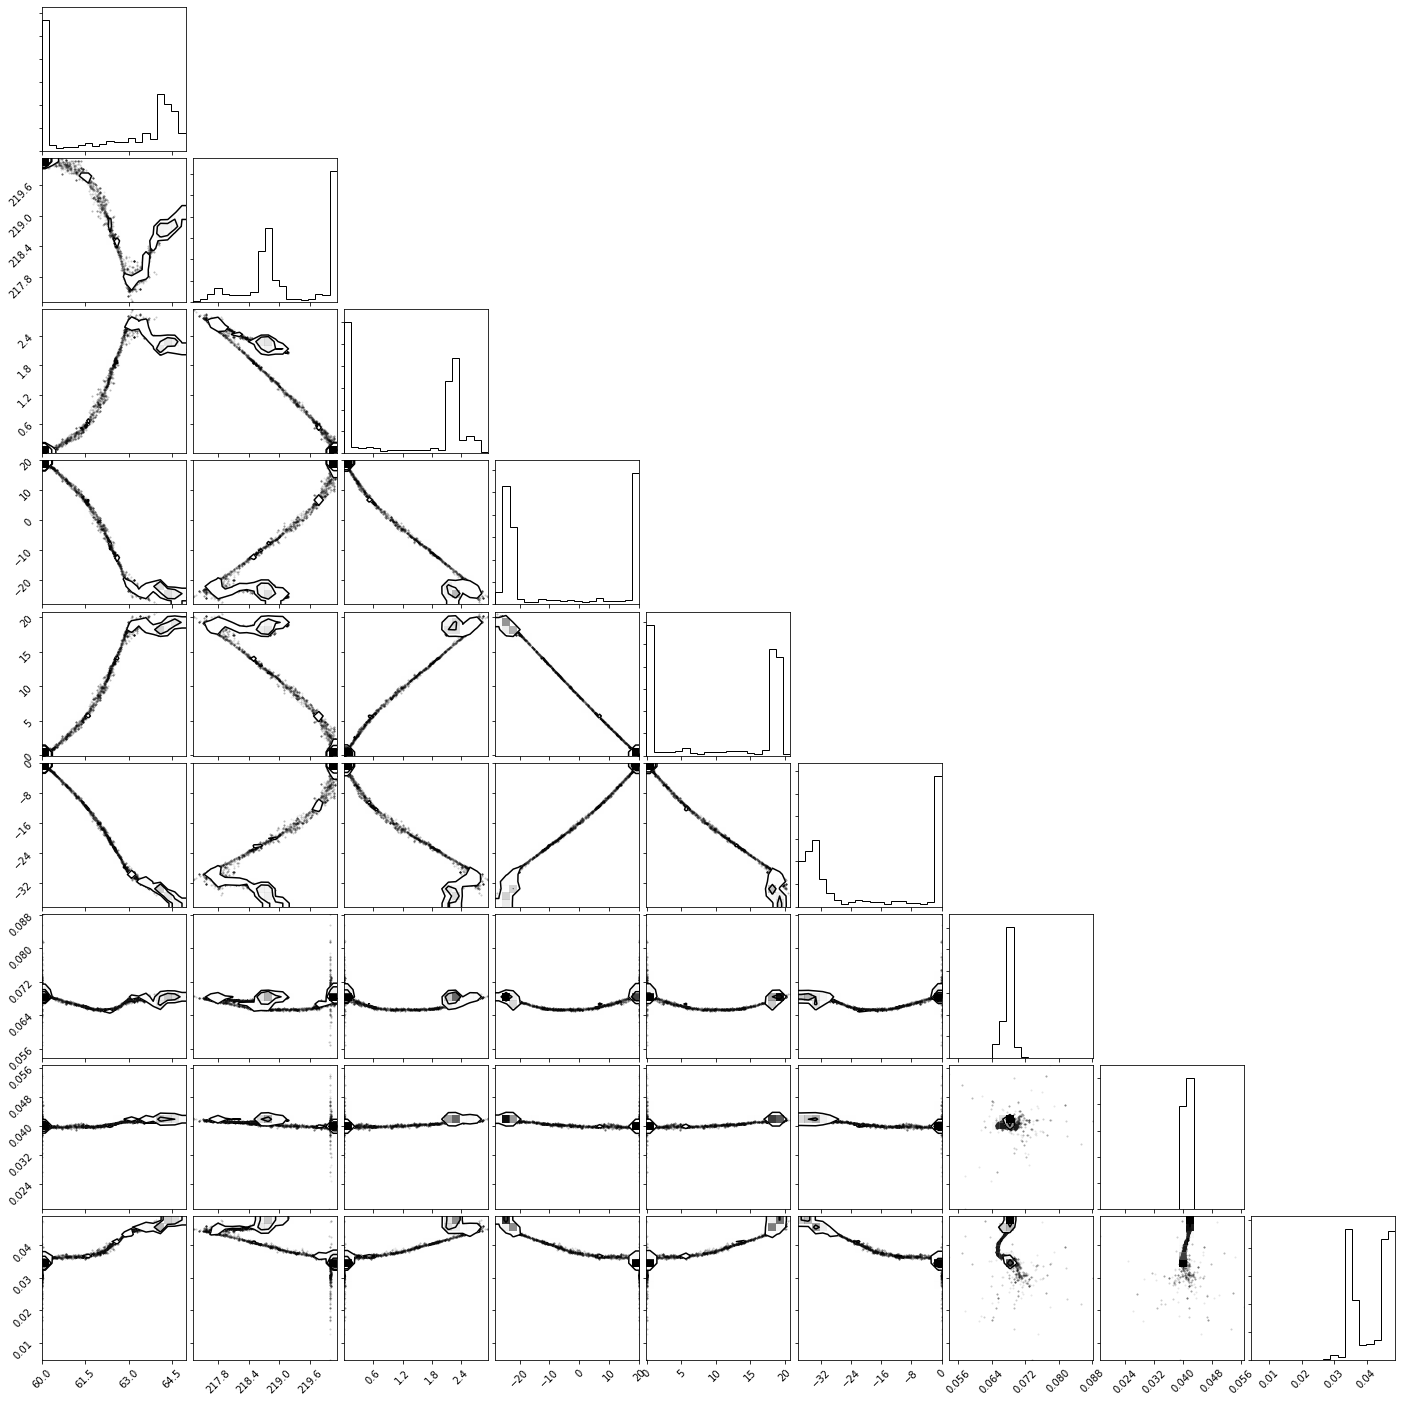

In [206]:
corner(sampler.flatchain);

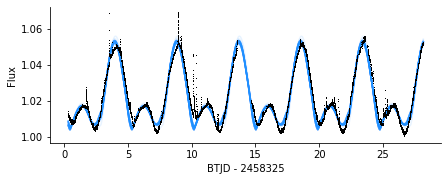

In [207]:
fig, ax = plt.subplots(figsize=(7, 2.5), sharex=True)

btjd_mid = int(astropy_time.jd.min())

ax.plot(astropy_time.jd - btjd_mid, 
           flux_observed, 'k,', zorder=10)

interp_times = np.linspace(astropy_time.jd.min(), astropy_time.jd.max(), 1000)
star.phases = (interp_times % prot) / prot

for i in np.random.randint(0, len(sampler.flatchain), size=50): 
    
    trial = sampler.flatchain[i, :]
        
    lons = trial[0:3]
    lats = trial[3:6]
    rads = trial[6:9]
    
    lc = star.light_curve(lons[:, None] * u.deg, lats[:, None] * u.deg, rads[:, None], 
                          inc_stellar=90*u.deg, times=interp_times, time_ref=0)[:, 0]
    ax.plot(interp_times - btjd_mid, lc, color='DodgerBlue', alpha=0.1)
    
ax.set(xlabel=f"BTJD - {btjd_mid}", ylabel='Flux')

# for axis in ax: 
for sp in ['right', 'top']: 
    ax.spines[sp].set_visible(False)

fig.savefig('plots/tess.pdf', bbox_inches='tight')
plt.show()